In [1]:
import torch
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
import os
import numpy as np
import cv2
import pickle
from tqdm import tqdm
import re

In [2]:
frame_dir = "frames/LPBF_Cyl"

In [3]:


checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

# predictor.reset_state(inference_state)
inference_state = predictor.init_state(video_path=frame_dir)

frame loading (JPEG): 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:30<00:00, 40.80it/s]


In [4]:

frame_names = [
    p for p in os.listdir(frame_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]

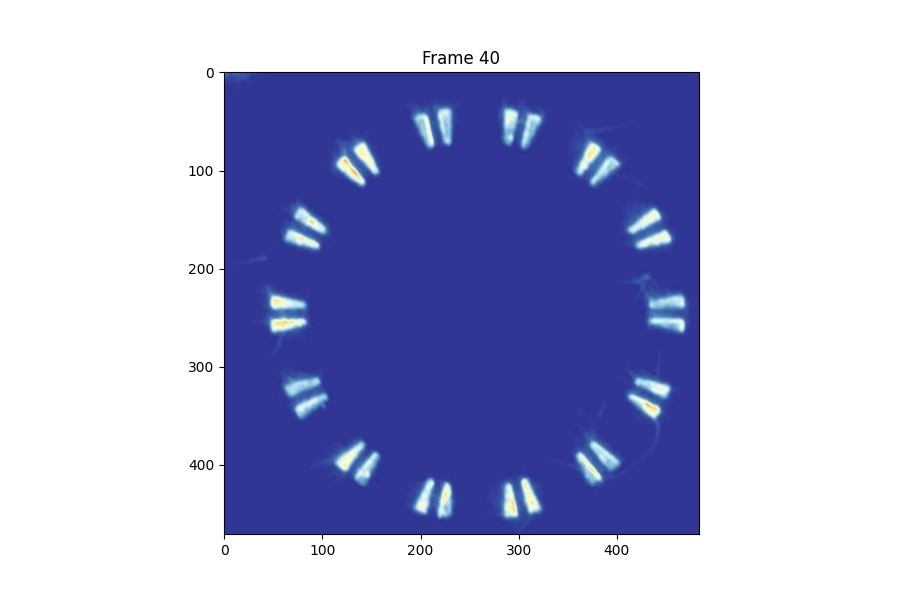

In [28]:
frame_idx = 40

img_path = os.path.join(frame_dir, frame_names[frame_idx])
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

points = []

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        # Koordinaten in int runden, falls gewünscht:
        x = int(event.xdata)
        y = int(event.ydata)
        points.append((x, y))
        print("Point:", (x, y))

# wichtig für JupyterLab
%matplotlib widget

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.set_title(f"Frame {frame_idx}")
ax.imshow(img)

# Event registrieren
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()


In [29]:
points


[(470, 159),
 (479, 224),
 (475, 264),
 (470, 304),
 (463, 345),
 (471, 403),
 (423, 412),
 (449, 441)]

In [30]:
#deactivate canvas frontend for normal plots
%matplotlib inline 

D:\fg-hybrid\PythonScripts\SAM2\sam2\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (D:\fg-hybrid\PythonScripts\SAM2\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


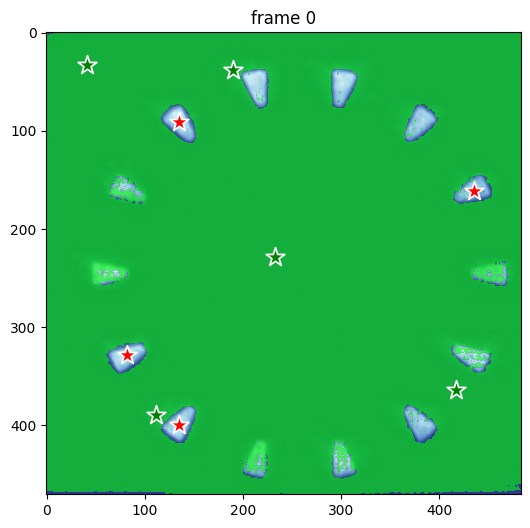

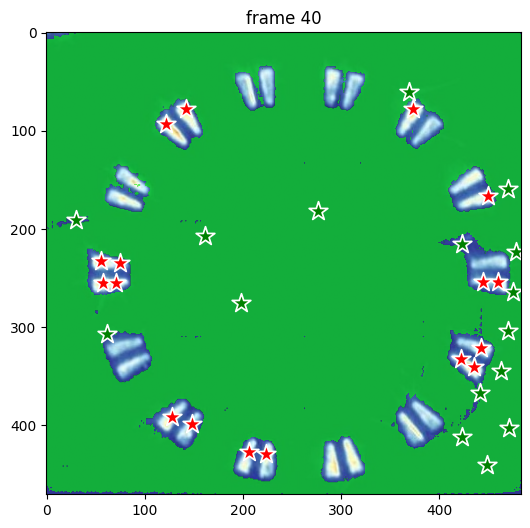

In [8]:

out_obj_ids, out_mask_logits = annotate_frame(
    "cylinder",
    0,
    np.array([
        (41, 33), (233, 229), (417, 364), (112, 390), (190, 38),
        (82, 329), (135, 400), (436, 161), (135, 91)
    ],
    dtype=np.float32),
    np.array([1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=np.int32), 
    frame_index=0,
    show_figure=True,
    color="green"
)

out_obj_ids, out_mask_logits = annotate_frame(
    "cylinder",
    0,
    np.array([
        (424, 215), (277, 182), (198, 276), (369, 60), (442, 367), (62, 307), (30, 191), (161, 207),
        (55, 233), (75, 235), (58, 255), (71, 255), (436, 341), (422, 333), (443, 321), (460, 254), (445, 254), (450, 166), (374, 78), (122, 93), (142, 78), (128, 392), (148, 399), (206, 427), (224, 429),
        (470, 159), (479, 224), (475, 264), (470, 304), (463, 345), (471, 403), (423, 412), (449, 441)
       
    ],
    dtype=np.float32),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,1, 1, 1, 1, 1, 1, 1, 1], dtype=np.int32), 
    frame_index=40,
    show_figure=True,
    color="green"
)



In [9]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

#with open("pickle_files/LPBF_Karsten25_CYL_INV.pkl", "wb") as f:
#    pickle.dump(video_segments, f)

propagate in video: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1242/1242 [2:57:22<00:00,  8.57s/it]


# Validate

In [ ]:
with open("pickle_files/LPBF_Karsten25_CYL.pkl", "rb") as f:
    video_segments = pickle.load(f)
vis_frame_stride = 100
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(frame_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [13]:
# feste Farben pro Klasse (BGR für OpenCV!)
CLASS_COLORS = {
    0: (0,   0, 255),   # Rot
    1: (0, 255,   0),   # Grün
    2: (255, 0,   0),   # Blau
    3: (0, 255, 255),   # Gelb
    4: (255, 0, 255),   # Magenta (falls weitere Klassen existieren)
    5: (255,255,  0),   # Cyan
}

for out_frame_idx in tqdm(range(len(frame_names)), desc="Processing frames"):

    sample_mask = next(iter(video_segments[out_frame_idx].values()))
    h, w = sample_mask.shape[-2:]
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # Für alle Segmente dieses Frames
    for cls_id, out_mask in video_segments[out_frame_idx].items():

        if cls_id not in CLASS_COLORS:
            continue  # ohne Farbdefinition überspringen
        
        mask = out_mask.reshape(h, w)
        b, g, r = CLASS_COLORS[cls_id]
        color_mask[mask] = (b, g, r)
   
    cv2.imwrite(
        f"frames/LPBF_CYL_MASK/{str(out_frame_idx).zfill(4)}.tif",
        color_mask
    )

Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:04<00:00, 298.27it/s]


In [ ]:
#only segment xxx
for out_frame_idx in tqdm(range(len(frame_names)), desc="Processing frames"):
    
    # Segment 0 aus dem aktuellen Frame holen
    out_mask = video_segments[out_frame_idx][0]   # nur Klasse 0

    h, w = out_mask.shape[-2:]

    # Boolean -> uint8 Maske (0 / 255)
    mask_image = (out_mask.reshape(h, w) * 255).astype(np.uint8)

    # Als TIFF speichern
    cv2.imwrite(
        f"frames/LPBF_Karsten25_mask2/{str(out_frame_idx).zfill(4)}.tif",
        mask_image
    )

# Helper functions

In [5]:
def annotate_frame(name, object_id, points, labels, frame_index=0, show_figure=True, color=None):
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=frame_index,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

    #if show_figure:
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {frame_index}")
    plt.imshow(Image.open(os.path.join(frame_dir, frame_names[frame_index])))
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[object_id] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[object_id], color=color)

    return out_obj_ids, out_mask_logits

In [6]:
def preprocess(raw_dir, frame_dir):
    sorted_files = sorted(os.listdir(raw_dir), key=lambda f: int(f.split("_")[1]))
    count = 0;
    for f in sorted_files:
        img = cv2.imread(os.path.join(raw_dir, f))
        #img_cropped = img[160:1400,:1400]
        #(218, 241), (702, 712)
        img_cropped = img[241:712,218:702]
        cv2.imwrite(os.path.join(frame_dir, f"{count:04d}.jpg"), img_cropped)
        count += 1

def crop(raw_dir, out_dir):
    sorted_files = [f for f in sorted(os.listdir(raw_dir))
                    if f.lower().endswith((".jpg", ".png", ".tif", ".jpeg"))]

    count = 0;
    for count, f in enumerate(tqdm(sorted_files, desc="Cropping")):
        img = cv2.imread(os.path.join(raw_dir, f))
        #(218, 241), (702, 712)
        img_cropped = img[241:712,218:702]
        cv2.imwrite(os.path.join(out_dir, f"{count:04d}.jpg"), img_cropped)
        count += 1

        


#preprocess("raw/01", frame_dir)
#crop(f"frames/LPBF_Karsten25", f"frames/LPBF_CYL")


In [7]:
def show_mask(mask, ax, obj_id=None, color=None):
    color_map = {
        "red": np.concatenate([np.array([1.0, 0.0, 0.0]), np.array([0.6])], axis=0),
        "green": np.concatenate([np.array([0.0, 1.0, 0.0]), np.array([0.6])], axis=0),
        "blue": np.concatenate([np.array([0.0, 0.0, 1.0]), np.array([0.6])], axis=0),
    }
    
    if color is None:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = color_map[color]
        
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))